In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


digits = load_digits()
X = digits.data
Y = digits.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
Y_train, Y_test = torch.LongTensor(Y_train), torch.LongTensor(Y_test)
ds = TensorDataset(X_train, Y_train)
loader = DataLoader(ds, batch_size=32, shuffle=True)

In [2]:
from torch import nn


class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, p=0.5):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.drop(x)
        return x

In [3]:
from torch import optim

k = 100
mlp = nn.Sequential(
    CustomLinear(64, k),
    CustomLinear(k, k),
    CustomLinear(k, k),
    nn.Linear(k, 10)
)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters())

In [4]:
from torch.autograd import Variable as V


train_losses = []
test_losses = []
for epoch in range(100):
    running_loss = 0.0
    # ネットワークを訓練モードに切り替える
    mlp.train()
    for i, (x, y) in enumerate(loader):
        xx = V(x)
        yy = V(y)
        y_pred = mlp(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
    train_losses.append(running_loss / i)
    y_pred = mlp(V(X_test))
    # ネットワークを評価モードに切り替える
    mlp.eval()
    test_loss = loss_fn(y_pred, V(Y_test))
    test_losses.append(test_loss.data[0])

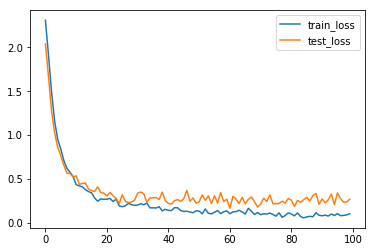

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt


plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend(loc='upper right')

In [6]:
# さらにモジュール化する、ついでにバッチノーマリゼーションつける
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, p=0.5):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.batch_norm(x)
        x = self.drop(x)
        return x

In [7]:
k = 100


class MyMLP(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in1 = CustomLinear(in_features, k)
        self.in2 = CustomLinear(k, k)
        self.in3 = CustomLinear(k, k)
        self.in4 = CustomLinear(k, k)
        self.in5 = nn.Linear(k, out_features)
        
    def forward(self, x):
        x = self.in1(x)
        x = self.in2(x)
        x = self.in3(x)
        x = self.in4(x)
        x = self.in5(x)
        return x

In [8]:
mlp = MyMLP(64, 10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters())

In [9]:
train_losses = []
test_losses = []
for epoch in range(100):
    running_loss = 0.0
    # ネットワークを訓練モードに切り替える
    mlp.train()
    for i, (x, y) in enumerate(loader):
        xx = V(x)
        yy = V(y)
        y_pred = mlp(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
    train_losses.append(running_loss / i)
    y_pred = mlp(V(X_test))
    # ネットワークを評価モードに切り替える
    mlp.eval()
    test_loss = loss_fn(y_pred, V(Y_test))
    test_losses.append(test_loss.data[0])

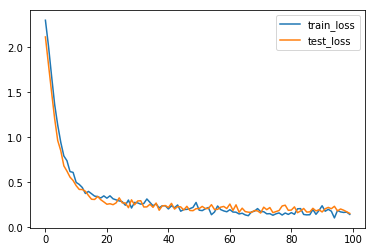

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt


plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend(loc='upper right')